# Designing Nonlinear Kalman Filters

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Introduction

**作者注：我最初计划有一个设计非线性章节来比较各种方法。 这可能会也可能不会发生，但目前本章没有有用的内容，我建议不要阅读.**

我们看到卡尔曼滤波器合理地跟踪球。 然而，正如已经解释过的，这是一个愚蠢的例子； 我们可以在真空中以任意精度预测轨迹； 在这个例子中使用卡尔曼滤波器是一种不必要的复杂化。

### Kalman Filter with Air Drag

我将省去第 1 步、第 2 步打字方法，并以您在非玩具工程问题中使用的更自然的方式进行处理。 我们已经开发了一种卡尔曼滤波器，它在真空中跟踪球方面表现出色，但没有将空气阻力的影响纳入模型。 我们知道流程模型是用 $\textbf{F}$ 实现的，所以我们将立即将注意力转向它。

理论上，$\textbf{F}$ 计算的计算是

$$x' = Fx$$

没有空气阻力，我们有

$$
\mathbf{F} = \begin{bmatrix}
1 & \Delta t & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & \Delta t & \frac{1}{2}{\Delta t}^2 \\
0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

这对应于方程

$$ 
\begin{aligned}
x &= x + v_x \Delta t \\
v_x &= v_x \\
\\
y &= y + v_y \Delta t + \frac{a_y}{2} {\Delta t}^2 \\
v_y &= v_y + a_y \Delta t \\
a_y &= a_y
\end{aligned}
$$

从上面的部分我们知道我们的新欧拉方程必须是

$$ 
\begin{aligned}
x &= x + v_x \Delta t \\
v_x &= v_x \\
\\
y &= y + v_y \Delta t + \frac{a_y}{2} {\Delta t}^2 \\
v_y &= v_y + a_y \Delta t \\
a_y &= a_y
\end{aligned}
$$

## Realistic 2D Position Sensors

最后一个例子中的位置传感器不太现实。 通常，没有提供 (x,y) 坐标的“原始”传感器。 我们有 GPS，但 GPS 已经使用卡尔曼滤波器来创建过滤输出； 我们不应该通过另一个卡尔曼滤波器来改善信号，除非我们加入额外的传感器来提供额外的信息。 我们稍后会解决这个问题。

考虑以下设置。 在开阔的场地中，我们在已知位置放置了两个发射器，每个发射器都发射我们可以检测到的信号。 我们处理信号并确定我们离该信号有多远，并带有一些噪声。 首先，让我们看一下它的视觉描述。

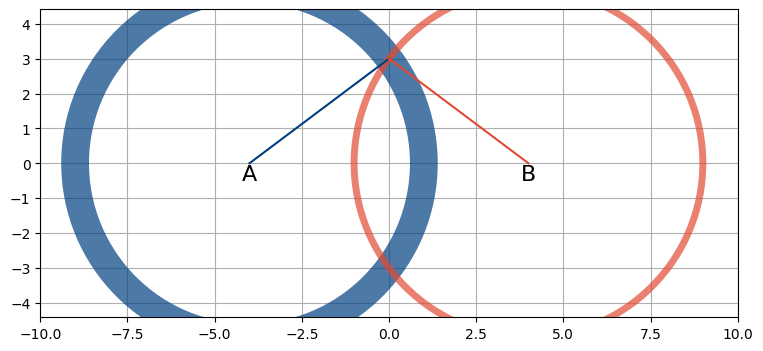

In [3]:
import matplotlib.pyplot as plt

circle1=plt.Circle((-4, 0), 5, color='#004080', 
                   fill=False, linewidth=20, alpha=.7)
circle2=plt.Circle((4, 0), 5, color='#E24A33', 
                   fill=False, linewidth=5, alpha=.7)

fig = plt.gcf()
ax = fig.gca()

plt.axis('equal')
plt.xlim((-10, 10))
plt.ylim((-10, 10))

plt.plot ([-4, 0], [0, 3], c='#004080')
plt.plot ([4, 0], [0, 3], c='#E24A33')
plt.text(-4, -.5, "A", fontsize=16, horizontalalignment='center')
plt.text(4, -.5, "B", fontsize=16, horizontalalignment='center')

ax.add_artist(circle1)
ax.add_artist(circle2)
plt.show()

在这里，我试图显示发射机 A，以红色绘制，位于 (-4,0)，第二个 B，以蓝色绘制，位于 (4,0)。红色和蓝色圆圈表示从发射器到机器人的范围，宽度表示每个发射器的 $1\sigma$ 角度误差的影响。在这里，我给蓝色发射器的误差比红色发射器的误差大。机器人最可能的位置是两个圆圈相交的位置，我用红线和蓝线描绘了它。你会反对我们有两个交点，而不是一个，但我们会在设计测量功能时看到我们如何处理它。

这是一种非常常见的传感器设置。飞机仍然使用这个系统来导航，它被称为 DME（距离测量设备）。今天 GPS 是一个更常见的导航系统，但我曾在飞机上工作，我们将这样的传感器与 GPS、INS、高度计等一起集成到我们的过滤器中。我们稍后将解决所谓的*多传感器融合* ;现在我们将只解决这个简单的配置。

第一步是设计我们的状态变量。我们将假设机器人以恒定速度沿直线方向行进。这在很长一段时间内不太可能是正确的，但在短时间内是可以接受的。这与之前的问题没有什么不同 - 我们将要跟踪机器人的位置和速度的值。因此，

$$\mathbf{x} = 
\begin{bmatrix}x\\v_x\\y\\v_y\end{bmatrix}$$

下一步是设计状态转移函数。 这也将与之前的问题相同，所以不用多说，

$$
\mathbf{x}' = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\mathbf{x}$$

下一步是设计控制输入。 我们没有，所以我们设置 ${\mathbf{B}}=0$。

下一步是设计测量函数 $\mathbf{z} = \mathbf{Hx}$。 我们可以使用勾股定理对测量进行建模。

$$
z_a = \sqrt{(x-x_A)^2 + (y-y_A)^2} + v_a\\[1em]
z_b = \sqrt{(x-x_B])^2 + (y-y_B)^2} + v_b
$$

我们看到了一个迫在眉睫的问题。 卡尔曼滤波器是为线性方程设计的，这显然是非线性的。 在接下来的章节中，我们将研究几种以稳健的方式处理非线性问题的方法，但现在我们将做一些更简单的事情。 如果我们知道机器人的大致位置，那么我们就可以围绕该点线性化这些方程。 我现在可以为这项技术开发广义数学，但让我只展示工作示例，为该开发提供背景。

我们将计算 $\mathbf{H}$ 相对于机器人位置 $\mathbf{x}$ 的偏导数，而不是计算 $\mathbf{H}$。 您可能熟悉偏导数的概念，但如果不熟悉，它仅表示 $\mathbf{H}$ 相对于机器人的位置如何变化。 它被计算为 $\mathbf{H}$ 的偏导数，如下所示：

$$\frac{\partial \mathbf{h}}{\partial \mathbf{x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

让我们计算一阶偏导数。 我们想找到

$$\frac{\partial }{\partial x} \sqrt{(x-x_A)^2 + (y-y_A)^2}
$$

我们计算为

$$
\begin{aligned}
\frac{\partial h_1}{\partial x} &= ((x-x_A)^2 + (y-y_A)^2))^\frac{1}{2} \\
&= \frac{1}{2}\times 2(x-x_a)\times ((x-x_A)^2 + (y-y_A)^2))^{-\frac{1}{2}} \\
&= \frac{x_r - x_A}{\sqrt{(x_r-x_A)^2 + (y_r-y_A)^2}} 
\end{aligned}
$$

我们继续计算两个距离方程关于 $x$、$y$、$dx$ 和 $dy$ 的偏导数，得到

$$\frac{\partial\mathbf{h}}{\partial\mathbf{x}}=
\begin{bmatrix}
\frac{x_r - x_A}{\sqrt{(x_r-x_A)^2 + (y_r-y_A)^2}} & 0 & 
\frac{y_r - y_A}{\sqrt{(x_r-x_A)^2 + (y_r-y_A)^2}} & 0 \\
\frac{x_r - x_B}{\sqrt{(x_r-x_B)^2 + (y_r-y_B)^2}} & 0 &
\frac{y_r - y_B}{\sqrt{(x_r-x_B)^2 + (y_r-y_B)^2}} & 0 \\
\end{bmatrix}
$$

这是非常痛苦的，而且这些是非常简单的方程。 对于更复杂的系统，计算雅可比行列式可能极其困难甚至不可能。 但是，通过使用 SymPy 模块 [1]，有一种简单的方法可以让 Python 为您完成工作。 SymPy 是一个用于符号数学的 Python 库。 它的全部能力超出了本书的范围，但它可以执行代数、积分和微分方程、找到微分方程的解等等。 我们将使用它来计算我们的雅可比行列式！

首先，一个简单的例子。 我们将导入 SymPy，初始化其漂亮的打印功能（将使用 LaTeX 打印方程）。 然后我们将声明一个符号供 NumPy 使用。

In [4]:
import sympy
from sympy import init_printing
init_printing(use_latex='mathjax')

phi, x = sympy.symbols('\phi, x')
phi

\phi

请注意我们如何为符号“phi”使用乳胶表达式。 这不是必需的，但如果你这样做，它会在输出时呈现为 LaTeX。 现在让我们做一些数学运算。 $\sqrt{\phi}$ 的导数是什么？

In [5]:
sympy.diff('sqrt(phi)')

 1  
────
2⋅√φ

我们可以分解方程。

In [6]:
sympy.factor('phi**3 -phi**2 + phi - 1')

        ⎛ 2    ⎞
(φ - 1)⋅⎝φ  + 1⎠

SymPy 有一个非凡的功能列表，尽管我很喜欢使用它的功能，但我们无法在此处全部介绍。 相反，让我们计算雅可比行列式。

In [7]:
from sympy import symbols, Matrix
phi = symbols('\phi')
phi

x, y, xa, xb, ya, yb, dx, dy = symbols('x y x_a x_b y_a y_b dx dy')

H = Matrix([[sympy.sqrt((x-xa)**2 + (y-ya)**2)], 
            [sympy.sqrt((x-xb)**2 + (y-yb)**2)]])

state = Matrix([x, dx, y, dy])
H.jacobian(state)

⎡           x - xₐ                           y - yₐ              ⎤
⎢ ──────────────────────────   0   ──────────────────────────   0⎥
⎢    _______________________          _______________________    ⎥
⎢   ╱         2           2          ╱         2           2     ⎥
⎢ ╲╱  (x - xₐ)  + (y - yₐ)         ╲╱  (x - xₐ)  + (y - yₐ)      ⎥
⎢                                                                ⎥
⎢          x - x_b                          y - y_b              ⎥
⎢────────────────────────────  0  ────────────────────────────  0⎥
⎢   _________________________        _________________________   ⎥
⎢  ╱          2            2        ╱          2            2    ⎥
⎣╲╱  (x - x_b)  + (y - y_b)       ╲╱  (x - x_b)  + (y - y_b)     ⎦

简而言之，条目 (0,0) 包含机器人的 x 坐标与发射机 A 的 x 坐标之间的差值除以机器人与 A 之间的距离。 (2,0) 包含相同，除了 y 坐标 机器人和发射器。 底行包含相同的计算，除了发射机 B。0 条目说明状态变量的速度分量； 当然，范围不会为我们提供速度。

该矩阵中的值随着机器人位置的变化而变化，因此不再是常数； 我们将不得不为过滤器的每个时间步长重新计算它。

如果你看这个，你可能会意识到这只是 x/dist 和 y/dist 的计算，所以我们可以将其转换为三角形式而不失一般性：

$$\frac{\partial\mathbf{h}}{\partial\mathbf{x}}=
\begin{bmatrix}
-\cos{\theta_A} & 0 & -\sin{\theta_A} & 0 \\
-\cos{\theta_B} & 0 & -\sin{\theta_B} & 0
\end{bmatrix}
$$

然而，这带来了一个巨大的问题。 我们不再计算 $\mathbf{H}$，而是 $\Delta\mathbf{H}$，$\mathbf{H}$ 的变化。 如果我们将其传递到我们的卡尔曼滤波器而不改变设计的其余部分，输出将是无意义的。 回想一下，例如，我们乘以 $\mathbf{Hx}$ 以生成由 $\mathbf{x}$ 的给定估计得出的测量值但是现在 $\mathbf{H}$ 围绕我们的位置线性化了 包含测量功能中的*变化*。

因此，我们被迫将 $\mathbf{x}$ 中的 *change* 用于我们的状态变量。 所以我们必须回去重新设计我们的状态变量。

> 请注意，这是设计卡尔曼滤波器时完全正常的现象。 教科书将这样的例子描述为 *fait accompli*，好像很明显状态变量需要是速度，而不是位置。 也许一旦你做了足够多的这些问题，它就会变得微不足道，但在这一点上，你为什么要阅读教科书？ 我发现自己通读了多次演示文稿，试图弄清楚他们做出选择的原因，最终意识到这是因为下一页上某事的后果。 我的演示文稿较长，但它反映了设计过滤器时实际发生的情况。 您做出看似合理的设计选择，并且随着您的前进，您会发现需要您重铸早期步骤的属性。 因此，我将在某种程度上放弃我的**步骤 1**、**步骤 2** 等方法，因为许多实际问题并不是那么简单。

如果我们的状态变量包含机器人的速度而不是位置，那么我们如何跟踪机器人的位置？我们不能。以这种方式线性化的卡尔曼滤波器使用所谓的*名义轨迹* - 即假设位置和轨迹方向，然后应用速度和加速度的变化来计算该轨迹的变化。不然怎么可能？回想一下显示两个范围圆相交的图形 - 有两个相交区域。想想如果两个发射器彼此非常靠近会是什么样子 - 交叉点将是两个非常长的新月形。按照设计，这种卡尔曼滤波器无法仅从到发射机的距离测量中获知您的真实位置。也许您的头脑已经开始寻找解决这个问题的方法。如果是这样，请保持参与，因为后面的部分和章节将为您提供这些技巧。在我看来，一次性提出完整的解决方案会导致更多的混乱而不是洞察力。

所以让我们重新设计我们的*状态转换函数*。我们假设恒定速度和无加速度，给出状态方程

$$
\dot{x}' = \dot{x} \\
\ddot{x}' = 0 \\
\dot{y}' = \dot{y} \\
\dot{y}' = 0$$

这给了我们*状态转换函数*

$$
\mathbf{F} = \begin{bmatrix}0 &1 & 0& 0\\0& 0& 0& 0\\0& 0& 0& 1\\ 0& 0& 0& 0\end{bmatrix}
$$

最后一个复杂因素来自我们传入的测量值。 $\mathbf{Hx}$ 现在正在计算从我们的名义位置开始的测量值的*变化*，因此我们传入的测量值不需要是到 A 和 B，但是从我们的测量范围到我们的标称位置的范围内的*变化*。

这里有很多东西需要学习，所以让我们一点一点地完成代码。 首先，我们将定义一个函数来为每个时间步计算 $\frac{\partial\mathbf{h}}{\partial\mathbf{x}}$。

In [8]:
from math import sin, cos, atan2

def H_of(pos, pos_A, pos_B):
    """ Given the position of our object at 'pos' in 2D, and two 
    transmitters A and B at positions 'pos_A' and 'pos_B', return 
    the partial derivative of H
    """

    theta_a = atan2(pos_a[1] - pos[1], pos_a[0] - pos[0])
    theta_b = atan2(pos_b[1] - pos[1], pos_b[0] - pos[0])

    return np.array([[0, -cos(theta_a), 0, -sin(theta_a)],
                     [0, -cos(theta_b), 0, -sin(theta_b)]])

现在我们需要创建我们的模拟传感器。

In [9]:
from numpy.random import randn

class DMESensor(object):
    def __init__(self, pos_a, pos_b, noise_factor=1.0):
        self.A = pos_a
        self.B = pos_b
        self.noise_factor = noise_factor
        
    def range_of(self, pos):
        """ returns tuple containing noisy range data to A and B
        given a position 'pos'
        """
        
        ra = math.sqrt((self.A[0] - pos[0])**2 + (self.A[1] - pos[1])**2)
        rb = math.sqrt((self.B[0] - pos[0])**2 + (self.B[1] - pos[1])**2)
        
        return (ra + randn()*self.noise_factor, 
                rb + randn()*self.noise_factor)

最后，我们为卡尔曼滤波器代码做好了准备。 我会将发射器定位在 x=-100 和 100 处，y=-20。 这给了我足够的空间来在机器人移动时从两者中获得良好的三角测量。 我将在 (0,0) 处启动机器人，并在每个时间步长移动 (1,1)。

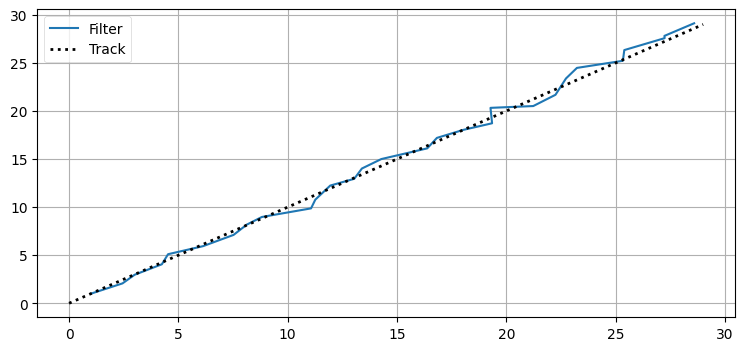

In [10]:
import kf_book.book_plots as bp
from filterpy.kalman import KalmanFilter
import math
import numpy as np

pos_a = (100, -20)
pos_b = (-100, -20)

f1 = KalmanFilter(dim_x=4, dim_z=2)

f1.F = np.array ([[0, 1, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], dtype=float)

f1.R *= 1.
f1.Q *= .1

f1.x = np.array([[1, 0, 1, 0]], dtype=float).T
f1.P = np.eye(4) * 5.

# initialize storage and other variables for the run
count = 30
xs, ys = [], []
pxs, pys = [], []

# create the simulated sensor
d = DMESensor(pos_a, pos_b, noise_factor=3.)

# pos will contain our nominal position since the filter does not
# maintain position.
pos = [0, 0]

for i in range(count):
    # move (1,1) each step, so just use i
    pos = [i, i]
    
    # compute the difference in range between the nominal track
    # and measured ranges
    ra,rb = d.range_of(pos)
    rx,ry = d.range_of((pos[0] + f1.x[0, 0], pos[1] + f1.x[2, 0]))
    z = np.array([[ra - rx], [rb - ry]])

    # compute linearized H for this time step
    f1.H = H_of (pos, pos_a, pos_b)

    # store stuff so we can plot it later
    xs.append(f1.x[0, 0]+i)
    ys.append(f1.x[2, 0]+i)
    pxs.append(pos[0])
    pys.append(pos[1])
    
    # perform the Kalman filter steps
    f1.predict()
    f1.update(z)

bp.plot_filter(xs, ys)
bp.plot_track(pxs, pys)
plt.legend(loc=2)
plt.show()

## Linearizing the Kalman Filter

现在我们已经看到了一个线性化卡尔曼滤波器的例子，我们可以更好地理解数学。

我们首先假设一些函数 $\mathbf f$

## Example: A falling Ball

**作者注：暂时忽略此部分。**

在**设计卡尔曼滤波器**一章中，我首先考虑在真空中跟踪球，然后在大气中进行跟踪。 卡尔曼滤波器在真空中表现非常好，但在大气中偏离了球的路径。 让我们看看输出； 为了避免在本章中使用该章的代码，我将它们全部放在文件“ekf_internal.py”中。


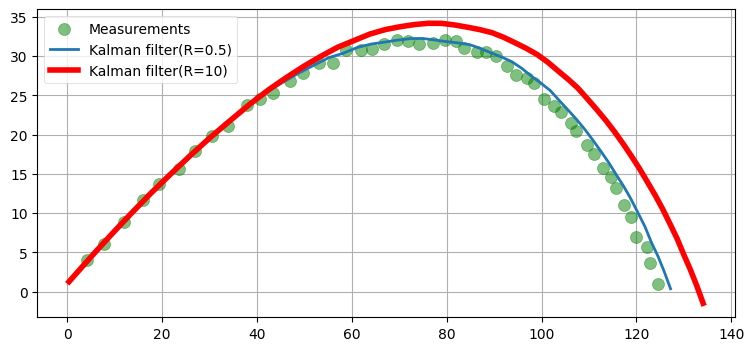

In [11]:
import kf_book.ekf_internal as ekf
ekf.plot_ball()

我们可以通过使 $Q$ 变大来人为地强制卡尔曼滤波器跟踪球。 这将导致过滤器不信任其预测，并缩放卡尔曼增益 $K$ 以强烈支持测量。 然而，这不是一个有效的方法。 如果卡尔曼滤波器正确预测了过程，我们不应该通过告诉滤波器存在不存在的过程错误来“撒谎”。 对于某些问题，在某些条件下，我们可能会逃脱，但总的来说，卡尔曼滤波器的性能会不合标准。

回忆一下**设计卡尔曼滤波器**一章，加速度是

$$a_x = (0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}})*v*v_x \\
a_y = (0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}})*v*v_y- g
$$

在我们开发这个主题时，使用这些方程将*非常*令人不快，所以现在我将退回到一个更简单的一维问题，使用这个简化的加速度方程，它没有考虑阻力系数的非线性：

$$\begin{aligned}
\ddot{y} &= \frac{0.0034ge^{-y/20000}\dot{y}^2}{2\beta} - g \\
\ddot{x} &= \frac{0.0034ge^{-x/20000}\dot{x}^2}{2\beta}
\end{aligned}$$

这里的 $\beta$ 是弹道系数，数字越大表示阻力越小。

这仍然是非线性的，所以我们需要在当前状态点对这个方程进行线性化。 如果我们的状态是位置和速度，我们需要一个方程来表示 $\mathbf{x}$ 的一些任意小的变化，如下所示：

$$ \begin{bmatrix}\Delta \dot{x} \\ \Delta \ddot{x} \\ \Delta \dot{y} \\ \Delta \ddot{y}\end{bmatrix} = 
\large\begin{bmatrix}
\frac{\partial \dot{x}}{\partial x} & 
\frac{\partial \dot{x}}{\partial \dot{x}} & 
\frac{\partial \dot{x}}{\partial y} & 
\frac{\partial \dot{x}}{\partial \dot{y}} \\ 
\frac{\partial \ddot{x}}{\partial x} & 
\frac{\partial \ddot{x}}{\partial \dot{x}}& 
\frac{\partial \ddot{x}}{\partial y}& 
\frac{\partial \dot{x}}{\partial \dot{y}}\\
\frac{\partial \dot{y}}{\partial x} & 
\frac{\partial \dot{y}}{\partial \dot{x}} & 
\frac{\partial \dot{y}}{\partial y} & 
\frac{\partial \dot{y}}{\partial \dot{y}} \\ 
\frac{\partial \ddot{y}}{\partial x} & 
\frac{\partial \ddot{y}}{\partial \dot{x}}& 
\frac{\partial \ddot{y}}{\partial y}& 
\frac{\partial \dot{y}}{\partial \dot{y}}
\end{bmatrix}\normalsize
\begin{bmatrix}\Delta x \\ \Delta \dot{x} \\ \Delta \dot{y} \\ \Delta \ddot{y}\end{bmatrix}$$

方程不包含 x 和 y，因此任何包含两者的偏导数都必须为零。 我们也知道 $\large\frac{\partial \dot{x}}{\partial x}\normalsize = 0$ 和 $\large\frac{\partial \dot{x}}{\partial \dot{ x}}\normalsize = 1$，所以我们的矩阵最终是

$$\mathbf{F} = \begin{bmatrix}0&1&0&0 \\
\frac{0.0034e^{-x/22000}\dot{x}^2g}{44000\beta}&0&0&0
\end{bmatrix}$$

$$\begin{aligned}\ddot{x} &= -\frac{1}{2}C_d\rho A \dot{x}\\
\ddot{y} &= -\frac{1}{2}C_d\rho A \dot{y}-g\end{aligned}$$

In [12]:
from sympy.abc import *
from sympy import *

init_printing(pretty_print=True, use_latex='mathjax')

x1 = (0.0034*g*exp(-x/22000)*((x)**2))/(2*b) - g

x2 = (a*g*exp(-x/c)*(Derivative(x)**2))/(2*b) - g

#pprint(x1)
#pprint(Derivative(x)*Derivative(x,n=2))
#pprint(diff(x2, x))

**孤立文本
这种方法有很多问题。首先，当然，线性化不会产生准确的答案。更重要的是，我们不是线性化实际路径，而是我们的过滤器对路径的估计。我们将估计线性化，因为它在统计上可能是正确的；但当然不是必须的。所以如果过滤器的输出不好，就会导致我们线性化一个不正确的估计，这几乎肯定会导致一个更糟糕的估计。在这些情况下，过滤器将迅速发散。这就是卡尔曼滤波器的“黑魔法”的用武之地。我们试图将估计线性化，但不能保证滤波器稳定。大量关于卡尔曼滤波器的文献专门讨论这个问题。另一个问题是我们需要使用解析方法对系统进行线性化。为某些问题找到分析解决方案可能很困难或不可能。在其他情况下，我们可能能够找到线性化，但计算非常昂贵**

## References

[1] http://sympy.org